# Predicting Service Demand in a City/Neighborhood

## Introduction

A pattern in the growth of services emerges with the growth of a city or neighborhood, affected along with its cultural and societal values. Kuhnert et al. (2006) had displayed examples of these patterns such as the logarithmic increase of the services such as petrol stations, pharmacies, clinics etc. Geoffrey West in his book called "Scale", has pointed out that in organism-like structures such as animals, cities and companies, there seems to be an optimal curve in relation to its size wherein values above this curve are organisms pushing its limits, and below the curve are organisms underutilizing its resources. With this line of thinking, it can be said that there must be a baseline in which it can be determined if a city or neighborhood still lacks the necessary services. 

Putting up a business and wondering which type of service is lacking in a certain neighborhood/city is surely a nerve-wracking experience especially for first-time entrepreneurs. Questions such as "Should I put up a laundry service?" or "Is there demand for an Asian restaurant in this neighborhood?" are some motivational examples. If information is available for these entrepreneurs, they will have an idea which of the types of services that are in short demand or in over-supply. In turn, they can have an easier time to weigh the pros and cons and scope into businesses that can potentially be profitable.  

Knowing which businesses are appropriate for a certain location/neighborhood are not only useful for entrepreneurs, but also for city governments. Having insight on which neighborhoods could use more or less of a certain type of service can be helpful in careful city planning. Also, questions about what it takes for a neighborhood/city to improve are also of interest. "Does a city need more roads?" or "Does a city need more connectivity to support the number of services/establishments?" are just some of the questions that might be crucial to answer. 





## Data Sources

### Overview
As this is only a proof of concept, this analysis will only include **cities/municipalities in the Philippines** with a clear hierarchical structure in terms of government units. In the Philippines, the usual government unit structure is shown below:

+ Region
    + Province
        + City
            + Barangay
 
 Since there is more interest in a more granular view, we need to put our sights at the *Barangay* level which is the most basic government unit in the Philippines.

### Location 
For this analysis, location data in Foursquare will be collected using the Foursquare location API. This will include primarily the category of a certain venue/service established in a barangay. As a start, we scope into food-related establishments. More types can be incorporated later on.

### Other important fields
Population information about these barangays are important to obtain as this was identified as an important variable in establishment count growth. Other-related fields that may be useful to describe how connected a city is are the total land mass of the City/Municipality, the number of roads, and the total road length. This will be obtained from [https://en.wikipedia.org/wiki/List_of_cities_and_municipalities_in_the_Philippines](). 

### Response 
To know if a certain city has an oversupply/undersupply of a certain service, the response to be used for this analysis are the number of establishments in a city for a venue category. 

## Data Preparation

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import lxml
import ssl
import requests


ssl._create_default_https_context = ssl._create_unverified_context

### Scraping population and land mass data from Wikipedia

Using information from wikipedia, I scrape the relevant population data for the different cities and municipalities in the Philippines. The final data frame should contain the *name of the city/municipality*, *population*, and *land area*. For now, only cities will be included due to the limited availability of coordinates. 

In [6]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_and_municipalities_in_the_Philippines'
popTable = pd.read_html(url)[3].iloc[:,0:7].query('Class == "CC"| Class == "HUC"|Class == "ICC"')

In [7]:
popTable.head()

,City or municipality,Population (2015)[1],Area (km2)[i][2][3],"PD (/km2, 2015)",Barangay,Class,Province
28,Butuan,337063,816.62,413,86,HUC,Agusan del Norte
29,Cabadbaran,73639,214.44,343,31,CC,Agusan del Norte
39,Bayugan,103202,688.77,150,43,CC,Agusan del Sur
75,Legazpi,196639,153.70,1279,70,CC,Albay
77,Ligao,111399,246.75,451,55,CC,Albay


The columns are then renamed to properly reflect the values in the columns.

In [8]:
popTable.dtypes

City or municipality    object
Population (2015)[1]    object
Area (km2)[i][2][3]     object
PD (/km2, 2015)         object
Barangay                object
Class                   object
Province                object
dtype: object

Change Area_km2 and pop_density to float, Population to int

In [9]:
popTable.rename(columns = {popTable.columns[0]: 'City', 
                          popTable.columns[1]: 'Population',
                          popTable.columns[2]: 'Area_km2',
                          popTable.columns[3]: 'pop_density'}, inplace = True)

Remove punctation marks in Area_km2 column 

In [10]:
import string

popTable['Area_km2'] = [s.translate(s.maketrans('', '', string.punctuation)) for s in popTable.Area_km2]

popTable[popTable.City == 'Manila']

,City,Population,Area_km2,pop_density,Barangay,Class,Province
1026,Manila,1780148,42889,41515,897,HUC,"NCR, City of Manila, 1st district"


Convert Population, Areak_m2, and pop_density columns to int and float objects.

In [11]:
def to_float(obj):
    try:
        return(float(obj))
    except:
        return(None)

def to_int(obj):
    try:
        return(int(obj))
    except:
        return(None)

popTable['Population'] = popTable.Population.apply(to_int)
popTable['Area_km2'] = popTable.Area_km2.apply(to_float)
popTable['pop_density'] = popTable.pop_density.apply(to_float)

In [12]:
popTable.dtypes

City            object
Population       int64
Area_km2       float64
pop_density    float64
Barangay        object
Class           object
Province        object
dtype: object

In [13]:
popTable.head()

,City,Population,Area_km2,pop_density,Barangay,Class,Province
28,Butuan,337063,81662.0,413.0,86,HUC,Agusan del Norte
29,Cabadbaran,73639,21444.0,343.0,31,CC,Agusan del Norte
39,Bayugan,103202,68877.0,150.0,43,CC,Agusan del Sur
75,Legazpi,196639,15370.0,1279.0,70,CC,Albay
77,Ligao,111399,24675.0,451.0,55,CC,Albay


In [14]:
popTable.describe()

,Population,Area_km2,pop_density
count,1.460000e+02,1.450000e+02,145.000000
mean,2.815388e+05,1.312187e+05,4130.193103
std,3.542287e+05,1.229947e+06,7378.899863
min,4.104100e+04,1.089000e+03,107.000000
25%,1.055082e+05,1.055300e+04,405.000000
50%,1.687515e+05,1.975600e+04,957.000000
75%,3.317580e+05,3.364000e+04,3748.000000
max,2.936116e+06,1.483381e+07,41515.000000


In [15]:
popTable.shape

(146, 7)

In [16]:
popTable.columns

Index(['City', 'Population', 'Area_km2', 'pop_density', 'Barangay', 'Class',
       'Province'],
      dtype='object')

#### Exploring Population Table

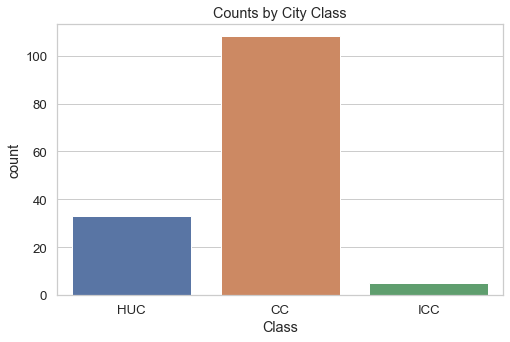

In [83]:
from matplotlib import pyplot

sns.set(font_scale = 1.2)
sns.set_style('whitegrid')
fig, ax = pyplot.subplots(figsize = (8, 5))
plt_Class_bplot = sns.countplot(x = 'Class', data = popTable)
plt_Class_bplot.set_title('Counts by City Class')

plt_Class_bplot


### Preparation of location data

Relevant latitude and longitude data for Cities in the Philipines was obtain from [https://simplemaps.com/data/ph-cities](). This will be used for querying venues for a particular city.

In [22]:
""""
import requests

#get_lat_long = def(loc):
S = requests.Session()

lat_long = []
for city, province in zip(popTable.City.values, popTable.Province.values):

    URL = "https://en.wikipedia.org/w/api.php"

    PARAMS = {
        "action": "query",
        "format": "json",
        "titles": city,
        "prop": "coordinates"
    }

    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()
    PAGES = DATA['query']['pages']
    
    try:
        [v for v in PAGES.items()][0][1]['coordinates']
        
    except:
        PARAMS['titles'] = city + ', ' + province
        R = S.get(url = URL, params = PARAMS)
        DATA = R.json()
        PAGES = DATA['query']['pages']
        

    for k, v in PAGES.items():
         
            a = [v['coordinates'][0]['lat'] ,v['coordinates'][0]['lon']]
     
    lat_long.append(a)
""""
    

SyntaxError: EOL while scanning string literal (<ipython-input-22-a05f3599fff1>, line 38)

Read longitude and latitude data for cities and municipalities in the Philippines. This was taken from a github repository under 

In [27]:
location_dat = pd.read_csv('locations_latlng.csv')
location_dat.head()

,Province,City,LatLng
0,Abra,Bangued,17.600; 120.617
1,Abra,Boliney,17.400; 120.800
2,Abra,Bucay,17.533; 120.717
3,Abra,Bucloc,17.450; 120.850
4,Abra,Daguioman,17.450; 120.917


In [28]:
location_dat.describe()

,Province,City,LatLng
count,1636,1636,1614
unique,80,1416,1610
top,Cebu,San Isidro,10.717; 122.267
freq,53,9,2


This data frame was then joined with the current `popTable` table to associate location data.

In [42]:
import re
cnd = popTable.City.apply(lambda x: np.where([bool(re.search(x, element)) for element in np.array(location_dat.City.values)] )[0])
popTable['LongLat'] = [[location_dat.LatLng.values[sub_item] for sub_item in item] for item in cnd]
city_info_table = popTable[popTable.LongLat.apply(len) == 1]
city_info_table['LongLat'] = [subitem for item in city_info_table.LongLat.values for subitem in item]
city_info_fnl = city_info_table[city_info_table.LongLat.isna() == False][city_info_table.Area_km2.isna() == False]

city_info_fnl['Latitude']  = city_info_fnl.LongLat.apply(lambda x: float(x.split(';')[0]))
city_info_fnl['Longitude']  = city_info_fnl.LongLat.apply(lambda x: float(x.split(';')[1]))

city_info_fnl.drop(columns = ['LongLat'], inplace = True)
city_info_fnl.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,City,Population,Area_km2,pop_density,Barangay,Class,Province,Latitude,Longitude
28,Butuan,337063,81662.0,413.0,86,HUC,Agusan del Norte,8.950,125.530
29,Cabadbaran,73639,21444.0,343.0,31,CC,Agusan del Norte,9.117,125.533
39,Bayugan,103202,68877.0,150.0,43,CC,Agusan del Sur,8.717,125.750
75,Legazpi,196639,15370.0,1279.0,70,CC,Albay,13.130,123.730
77,Ligao,111399,24675.0,451.0,55,CC,Albay,13.217,123.517


In [30]:
city_info_fnl.shape

(110, 9)

## Determine all venues in a city

In [38]:
CLIENT_ID = '0SO1TRZIQORZHKDFFX0KWSMEOCWSBGKVSF3UVCQUHGIWVVL3' #  Foursquare ID
CLIENT_SECRET = 'YOPKZ01NZKOVPXXZJCAC4YZUI52BS0JKX2DZ34EWFUTIE4SQ' #  Foursquare Secret
VERSION = '20180605' #  API version
LIMIT = 500

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            
     
            
        nearby_venues.columns = ['Neighborhood', 
                          'Neighborhood Latitude', 
                          'Neighborhood Longitude', 
                          'Venue', 
                          'Venue Latitude', 
                          'Venue Longitude', 
                          'Venue Category']
            
    
    return(nearby_venues)

To use this function, the radius was determined first from the area of the city

In [43]:
import math
city_info_fnl['radius'] = [math.sqrt(area/math.pi)*1000 for area in city_info_fnl.Area_km2]
city_info_fnl = city_info_fnl.set_index('City').drop(index = ['Malaybalay', 'Ilagan', 'Iligan', 'Quezon City', 'Puerto Princesa', 'Calbayog']).reset_index()

In [44]:
city_info_fnl.head()

,City,Population,Area_km2,pop_density,Barangay,Class,Province,Latitude,Longitude,radius
0,Butuan,337063,81662.0,413.0,86,HUC,Agusan del Norte,8.950,125.530,161225.996432
1,Cabadbaran,73639,21444.0,343.0,31,CC,Agusan del Norte,9.117,125.533,82618.625015
2,Bayugan,103202,68877.0,150.0,43,CC,Agusan del Sur,8.717,125.750,148068.328925
3,Legazpi,196639,15370.0,1279.0,70,CC,Albay,13.130,123.730,69945.857280
4,Ligao,111399,24675.0,451.0,55,CC,Albay,13.217,123.517,88624.468639


In [45]:
venue_list = getNearbyVenues(names = np.array(city_info_fnl.City), latitudes = np.array(city_info_fnl.Latitude), 
                            longitudes = np.array(city_info_fnl.Longitude), radius = np.array(city_info_fnl.radius))

Butuan
Cabadbaran
Bayugan
Legazpi
Ligao
Tabaco
Isabela City
Batangas City
Lipa
Baguio
Tagbilaran
Malolos
Meycauayan
San Jose del Monte
Tuguegarao
Iriga
Roxas City
Bacoor
Cavite City
Dasmariñas
General Trias
Imus
Tagaytay
Trece Martires
Bogo
Carcar
Cebu City
Mandaue
Toledo
Kidapawan
Panabo
Tagum
Digos
Mati
Borongan
Batac
Laoag
Vigan
Iloilo City
Passi
Tabuk
Biñan
Cabuyao
San Pedro
Marawi
Baybay
Ormoc
Tacloban
Cotabato City
Masbate City
Oroquieta
Ozamiz
Tangub
Cagayan de Oro
El Salvador
Gingoog
Caloocan
Las Piñas
Makati
Malabon
Mandaluyong
Manila
Marikina
Muntinlupa
Navotas
Parañaque
Pasay
Taguig
Bago
Cadiz
Escalante
Himamaylan
Kabankalan
Silay
Sipalay
Victorias
Bais
Canlaon
Dumaguete
Guihulngan
Tanjay
Cabanatuan
Gapan
Muñoz
Palayan
Calapan
Angeles
Mabalacat
Dagupan
Urdaneta
Tayabas
Antipolo
Catbalogan
Sorsogon City
Koronadal
Tacurong
Surigao City
Bislig
Tandag
Tarlac City
Olongapo
Dapitan
Dipolog
Pagadian


In [46]:
venue_list.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Butuan,8.95,125.53,Wat Ever Family KTV Butuan,8.946194,125.531061,Karaoke Bar
1,Butuan,8.95,125.53,Boy's Beer & Wine Room,8.946217,125.531236,Beer Garden
2,Butuan,8.95,125.53,Watergate Hotel,8.951037,125.529557,Hotel
3,Butuan,8.95,125.53,Almont Inland Resort Butuan,8.946409,125.529393,Resort
4,Butuan,8.95,125.53,Margie's,8.947072,125.535636,Café


In [47]:
venue_list.shape

(9746, 7)

Pickle this this list for future uses

In [49]:
import pickle

venue_list.to_pickle('venue_list.pkl')

Text(0.5, 1.0, 'Top 20 Venues in the Philippines')

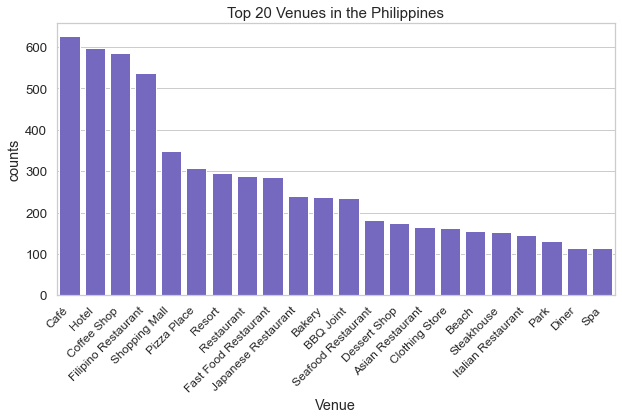

In [80]:
venue_counts = venue_list['Venue Category'].value_counts().reset_index() \
.rename(columns = {'index': 'Venue', 'Venue Category': 'counts'})

sns.set(font_scale = 1.2)
sns.set_style('whitegrid')
fig, ax = pyplot.subplots(figsize = (10, 5))
cnt1  = sns.barplot(x = 'Venue', y = 'counts', data = venue_counts.loc[0:21,:], color = 'slateblue')
cnt1.set_xticklabels(cnt1.get_xticklabels(), rotation = 45, fontsize = 12, horizontalalignment = 'right')
cnt1.set_title('Top 20 Venues in the Philippines', fontsize=15)

## Preparing data set for modeling

In [51]:
venue_list.rename(columns = {'Neighborhood':  'City'}, inplace = True)
venue_list_onehot = pd.get_dummies(venue_list[['Venue Category']], prefix = '', prefix_sep = '')
venue_list_onehot.insert(0, 'City', venue_list['City'])

venue_grouped = venue_list.groupby(['City', 'Venue Category']).size().reset_index().rename(columns = {0: 'Count'})
venue_list_onehot = pd.get_dummies(venue_grouped[['Venue Category']], prefix = '', prefix_sep = '')
venue_grouped_onehot = pd.concat([venue_grouped, venue_list_onehot], axis = 1) \
.join(city_info_fnl[['City','Population', 'Area_km2', 'pop_density']].set_index('City'), 
     on = 'City', how = 'left')


venue_grouped_onehot.head()



,City,Venue Category,Count,African Restaurant,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,...,Water Park,Waterfall,Windmill,Wine Bar,Wings Joint,Yoga Studio,Zoo,Population,Area_km2,pop_density
0,Angeles,American Restaurant,4,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,411634,6027.0,6830.0
1,Angeles,Asian Restaurant,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,411634,6027.0,6830.0
2,Angeles,BBQ Joint,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,411634,6027.0,6830.0
3,Angeles,Bakery,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,411634,6027.0,6830.0
4,Angeles,Bar,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,411634,6027.0,6830.0


In [93]:
venue_grouped_onehot['tot'] = venue_grouped_onehot[['Count', 'City']].groupby(['City']).transform('sum')
venue_grouped_onehot['prop'] = venue_grouped_onehot['Count']/venue_grouped_onehot['tot']

In [101]:
venue_grouped_onehot.head()

,City,Venue Category,Count,African Restaurant,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,...,Windmill,Wine Bar,Wings Joint,Yoga Studio,Zoo,Population,Area_km2,pop_density,tot,prop
0,Angeles,American Restaurant,4,0,0,0,1,0,0,0,...,0,0,0,0,0,411634,6027.0,6830.0,100,0.04
1,Angeles,Asian Restaurant,1,0,0,0,0,0,0,0,...,0,0,0,0,0,411634,6027.0,6830.0,100,0.01
2,Angeles,BBQ Joint,3,0,0,0,0,0,0,0,...,0,0,0,0,0,411634,6027.0,6830.0,100,0.03
3,Angeles,Bakery,1,0,0,0,0,0,0,0,...,0,0,0,0,0,411634,6027.0,6830.0,100,0.01
4,Angeles,Bar,1,0,0,0,0,0,0,0,...,0,0,0,0,0,411634,6027.0,6830.0,100,0.01


## Statistical Modeling

At this point, there is a need to choose just one sensible venue category to model. There is a need to make sure that venue categories are well-reviewed in Foursquare to avoid biases. For example, it maybe possible that bakeries are not well-reported due to the fact that not a lot of people review it. 

For this modeling exercise, I will model Venue Category **Hotel** and **Coffee Shop**. Furthermore, since the observed number of establishments that is currently in the data set is believed to be only a sample of the venues in a city, a `prop` value was derived which pertains to the proportion of establisments in a city.

In [107]:
Hotels_df = venue_grouped_onehot[venue_grouped_onehot['Venue Category'] == 'Hotel']
Hotels_df.shape


(101, 223)

In [114]:
Coffee_shop_df = venue_grouped_onehot[venue_grouped_onehot['Venue Category'] == 'Coffee Shop']
Coffee_shop_df.shape

(102, 223)

### Modeling of Proportions of hotels in a city 

#### Multiple linear regression (features: Population, population density)

In [118]:
from sklearn.linear_model import LinearRegression


X_hotels = Hotels_df[['Population', 'pop_density']]
Y_hotels_prop = Hotels_df['prop']

lr = LinearRegression()
lr.fit(X_hotels, Y_hotels_prop)

preds = lr.predict(X_hotels)
lr.score(X_hotels, Y_hotels_prop)

0.19894346544764918

Text(0, 0.5, 'Proportion of Hotels')

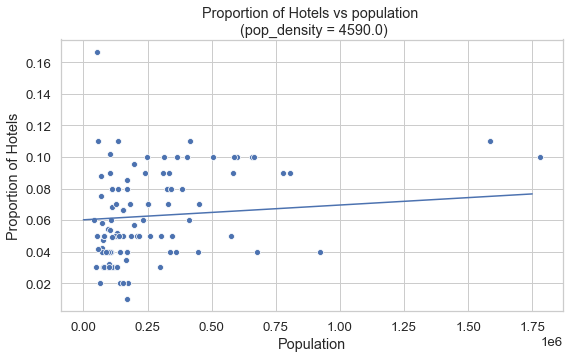

In [164]:
mean_pop_density = round(X_hotels.pop_density.mean(),-1)
forLineVals = pd.DataFrame({'Population': np.linspace(0, 1.75e6), 
                            'pop_density': mean_pop_density})

preds = lr.predict(forLineVals)
fig, ax = pyplot.subplots(figsize = (9, 5))
lplot = sns.lineplot(np.linspace(0, 1.75e6), preds)
sns.scatterplot(X_hotels['Population'], Y_hotels_prop)
lplot.set_title('Proportion of Hotels vs population \n (pop_density = {})'.format(mean_pop_density))
lplot.set_ylabel('Proportion of Hotels')


#### Features: log population; Response: log proportion

In [170]:
X_hotels['log_pop'] = Hotels_df['Population'].apply(math.log)
Y_hotels_prop_log = [math.log(pop) for pop in Y_hotels_prop]

lr_log_pop = LinearRegression()
lr_log_pop.fit(X_hotels[['log_pop']], Y_hotels_prop_log)
lr_log_pop.score(X_hotels[['log_pop']], Y_hotels_prop_log)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.12257692767451979

#### Features: log population, log population density; Response: log proportion

In [166]:
X_hotels['log_pop_dens'] = Hotels_df['pop_density'].apply(math.log)


lr_log = LinearRegression()
lr_log.fit(X_hotels[['log_pop', 'log_pop_dens']], Y_hotels_prop_log)
lr_log.score(X_hotels[['log_pop', 'log_pop_dens']], Y_hotels_prop_log)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0.15036961484133038

Text(0, 0.5, 'log Proportion of Hotels')

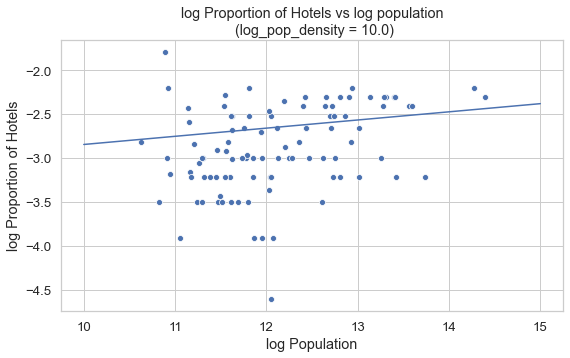

In [169]:
mean_pop_density = round(X_hotels.log_pop_dens.mean(),-1)
forLineVals = pd.DataFrame({'log_pop': np.linspace(10, 15), 
                            'log_pop_dens': mean_pop_density})

preds = lr_log.predict(forLineVals)
fig, ax = pyplot.subplots(figsize = (9, 5))
lplot = sns.lineplot(np.linspace(10,15), preds)
sns.scatterplot(X_hotels['log_pop'], Y_hotels_prop_log)
lplot.set_title(' log Proportion of Hotels vs log population \n (log_pop_density = {})'.format(mean_pop_density))
lplot.set_xlabel('log Population')
lplot.set_ylabel('log Proportion of Hotels')

In [167]:
lr_log.coef_

array([0.09292715, 0.08260048])